<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Financial Data Structures
    </h1>
  </div>  
</div>

This notebook provides a tutorial on using the `RiskLabAI` library to convert standard tick data into advanced financial data structures.

In this notebook, we will:
1.  Load and prepare raw tick data.
2.  Manually instantiate and build **Standard Bars** (Time, Tick, Volume, and Dollar).
3.  Analyze the statistical properties (frequency and normality) of these bars.
4.  Demonstrate how to build **Information-Driven Bars** (Imbalance and Run).
5.  Show the simplified **Controller-based workflow** for batch processing data.

## 0. Setup

First, we import all necessary libraries and configure our environment and plotting style.

In [ ]:
# --- 1. Standard Library Imports ---
import os
import warnings

# --- 2. Third-Party Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from dotenv import load_dotenv

# --- 3. RiskLabAI Library Imports ---
from RiskLabAI.data.structures.standard_bars import StandardBars
from RiskLabAI.data.structures.time_bars import TimeBars
from RiskLabAI.data.structures.imbalance_bars import ExpectedImbalanceBars
from RiskLabAI.data.structures.run_bars import ExpectedRunBars
from RiskLabAI.controller.data_structure_controller import Controller
from RiskLabAI.utils.constants import (
    CUMULATIVE_DOLLAR, 
    CUMULATIVE_VOLUME, 
    CUMULATIVE_TICKS
)
import RiskLabAI.utils.publication_plots as pub_plots

# --- 4. Environment and API Setup ---
# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()
# To run the code on your computer, register for a free FRED API and uncomment the following line
# FRED_API_KEY = 'YOUR_FRED_API_KEY'

# --- 5. Notebook Configuration ---
warnings.filterwarnings("ignore")

# Global Plotting Settings
SAVE_PLOTS = False  
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300  
SAVE_DIR = 'figs'   

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Load Data

We will use a publicly available tick dataset for the IVE ETF from 2020. The raw data is a list of tick data tuples: `(datetime, price, volume)`.

**Note on Data:** This notebook requires **tick-level data** to demonstrate bar aggregation. The requested FRED data source provides data at a *daily* or *monthly* frequency, which is not suitable for this specific application. We will proceed with the original tick-level CSV data.

In [ ]:
# Load the data from a public URL
data_url = "https://raw.githubusercontent.com/risk-labratory/data/main/IVE_2020.csv"
raw_df = pd.read_csv(data_url, parse_dates=['dates'])

# Filter for standard market hours (9:00 - 16:00)
raw_df = raw_df[
    (raw_df['dates'].dt.hour >= 9) & (raw_df['dates'].dt.hour < 16)
]

# The bar generation classes expect an iterable of tick data.
# We'll create a list of tuples: (datetime, price, volume)
# Note: We must sort by date first!
raw_df = raw_df.sort_values(by='dates').drop_duplicates()

# This iterable format is what the bar constructors expect
tick_data_iterable = [
    (row.dates, row.price, row.size) 
    for row in raw_df.itertuples(index=False)
]

print(f"Loaded {len(tick_data_iterable)} ticks.")

# Preview the first 5 ticks
print(tick_data_iterable[:5])

Loaded 283370 ticks.
[(Timestamp('2020-01-02 09:30:00'), 130.68, 20625), (Timestamp('2020-01-02 09:30:01'), 130.5, 200), (Timestamp('2020-01-02 09:30:04'), 130.53, 100), (Timestamp('2020-01-02 09:30:04'), 130.55, 100), (Timestamp('2020-01-02 09:30:04'), 130.53, 200)]


## 2. Standard Bars

Standard bars aggregate ticks by a fixed unit of time, ticks, volume, or dollars.

### 2.1. Helper Function

We'll create a helper function to convert the list-of-lists output from our library into a clean, labeled `pandas.DataFrame`.

In [ ]:
def bars_to_dataframe(bars_list: list) -> pd.DataFrame:
    """Converts the list output from bar constructors to a DataFrame."""
    
    # These are the column names our library generates
    # (from the `_construct_next_bar` method in `abstract_bars.py`)
    COL_NAMES = [
        'Date Time', 'Tick Index', 'Open', 'High', 'Low', 'Close',
        'Cumulative Volume', 'Cumulative Buy Volume', 'Cumulative Sell Volume',
        'Cumulative Ticks', 'Cumulative Dollar', 'Threshold'
    ]
    
    df = pd.DataFrame(bars_list, columns=COL_NAMES)
    df = df.set_index('Date Time')
    return df

### 2.2. Time Bars

Time bars are the most common, sampling at fixed time intervals (e.g., 15 minutes).

In [ ]:
# 1. Instantiate the TimeBars class
# We will sample every 15 minutes
time_bar_generator = TimeBars(resolution_type='MIN', resolution_units=15)

# 2. Construct the bars
time_bars_list = time_bar_generator.construct_bars_from_data(tick_data_iterable)

# 3. Convert to a DataFrame
time_bars = bars_to_dataframe(time_bars_list)

print(f"Generated {len(time_bars)} 15-minute time bars.")
time_bars.head()

Generated 6624 15-minute time bars.


,Tick Index,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar,Threshold
Date Time,,,,,,,,,,,
2020-01-02 09:45:00,192,130.68,130.78,130.4500,130.5400,143325,47675,95650,192,1.871823e+07,1577958300
2020-01-02 10:00:00,262,130.52,130.62,130.3700,130.4299,20723,10202,10521,70,2.703981e+06,1577959200
2020-01-02 10:15:00,305,130.40,130.40,130.2400,130.2400,14891,4149,10742,43,1.940535e+06,1577960100
2020-01-02 10:30:00,394,130.14,130.16,130.0218,130.0564,60336,33268,27068,89,7.849624e+06,1577961000
2020-01-02 10:45:00,475,130.08,130.08,129.9878,130.0600,21316,12784,8532,81,2.772359e+06,1577961900


### 2.3. Tick, Volume, and Dollar Bars

These bars are all generated by the `StandardBars` class. We just need to change the `bar_type` and `threshold`.

To set a reasonable threshold, we'll first calculate the daily averages and sample ~20 bars per day.

In [ ]:
# Get number of trading days
num_days = len(raw_df['dates'].dt.date.unique())

# Calculate daily averages
daily_ticks = len(raw_df) / num_days
daily_volume = raw_df['size'].sum() / num_days
daily_dollar = (raw_df['price'] * raw_df['size']).sum() / num_days

# Set thresholds to get ~20 bars per day
bars_per_day = 20
tick_threshold = daily_ticks / bars_per_day
volume_threshold = daily_volume / bars_per_day
dollar_threshold = daily_dollar / bars_per_day

print(f"Tick Threshold: {tick_threshold:,.0f}")
print(f"Volume Threshold: {volume_threshold:,.0f}")
print(f"Dollar Threshold: {dollar_threshold:,.0f}")

# --- Generate Tick Bars ---
tick_bar_generator = StandardBars(
    bar_type=CUMULATIVE_TICKS, 
    threshold=tick_threshold
)
tick_bars_list = tick_bar_generator.construct_bars_from_data(tick_data_iterable)
tick_bars = bars_to_dataframe(tick_bars_list)

# --- Generate Volume Bars ---
volume_bar_generator = StandardBars(
    bar_type=CUMULATIVE_VOLUME, 
    threshold=volume_threshold
)
volume_bars_list = volume_bar_generator.construct_bars_from_data(tick_data_iterable)
volume_bars = bars_to_dataframe(volume_bars_list)

# --- Generate Dollar Bars ---
dollar_bar_generator = StandardBars(
    bar_type=CUMULATIVE_DOLLAR, 
    threshold=dollar_threshold
)
dollar_bars_list = dollar_bar_generator.construct_bars_from_data(tick_data_iterable)
dollar_bars = bars_to_dataframe(dollar_bars_list)

print(f"\nGenerated {len(tick_bars)} Tick Bars")
print(f"Generated {len(volume_bars)} Volume Bars")
print(f"Generated {len(dollar_bars)} Dollar Bars")

Tick Threshold: 56
Volume Threshold: 24,686
Dollar Threshold: 2,737,634

Generated 4971 Tick Bars
Generated 4184 Volume Bars
Generated 4162 Dollar Bars


## 3. Analysis: Standard Bars

Now, we'll replicate the analyses to show *why* Dollar Bars are a superior data structure.

### 3.1. Analysis 1: Bar Count Stability

This plot shows the number of bars generated per week. Time bars are constant, while the others adapt to market activity.

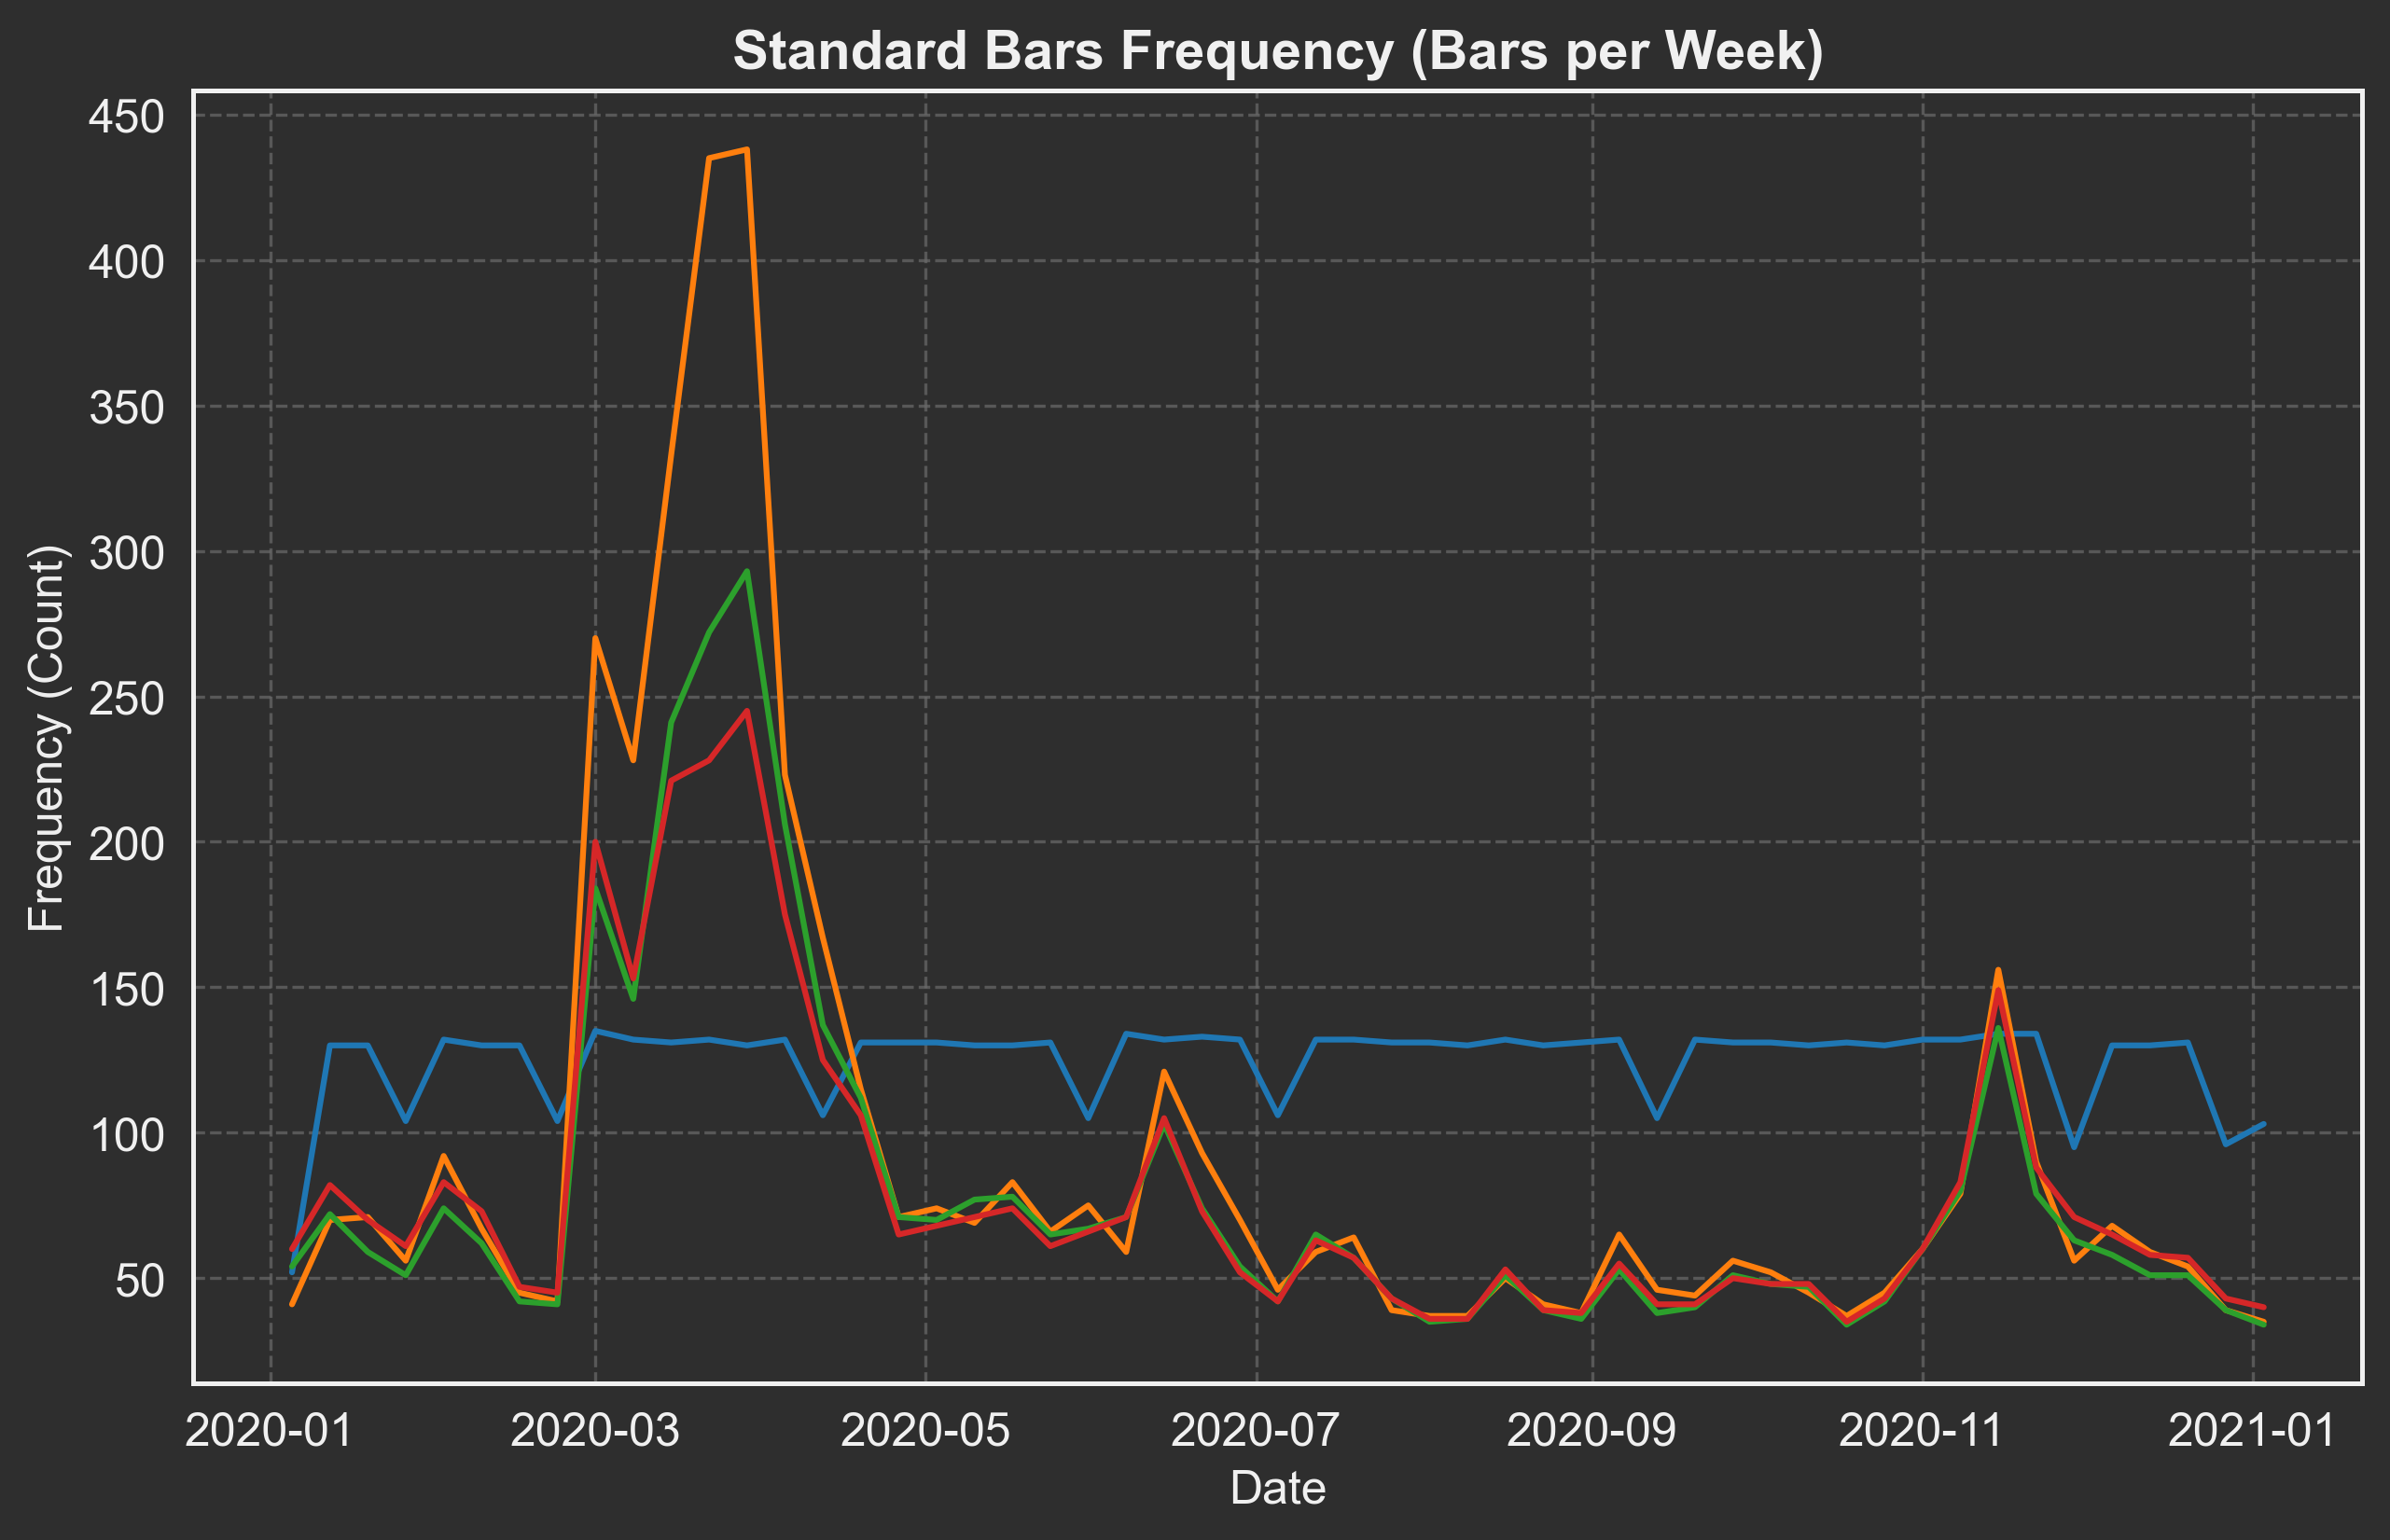

In [ ]:
# Resample each bar type to get the count per week
count_df = pd.DataFrame({
    'Time': time_bars['Close'].resample('1W').count(),
    'Tick': tick_bars['Close'].resample('1W').count(),
    'Volume': volume_bars['Close'].resample('1W').count(),
    'Dollar': dollar_bars['Close'].resample('1W').count(),
}).dropna()


# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(count_df.index, count_df['Time'], label='Time')
ax.plot(count_df.index, count_df['Tick'], label='Tick')
ax.plot(count_df.index, count_df['Volume'], label='Volume')
ax.plot(count_df.index, count_df['Dollar'], label='Dollar')

pub_plots.apply_plot_style(
    ax,
    title='Standard Bars Frequency (Bars per Week)',
    xlabel='Date',
    ylabel='Frequency (Count)',
    legend_title='Bar Type'
)

# Use the finalize_plot function from our library
pub_plots.finalize_plot(fig, "standard_bars_frequency.png")

**Observation:** As expected, Time bars have a perfectly constant frequency. Tick, Volume, and Dollar bars show a huge spike in activity during the March 2020 COVID-19 crash. This shows they are adapting to market volatility.

### 3.2. Analysis 2: Normality of Returns

The primary goal of these bars is to create a return series that is closer to the 'Normal' distribution (IID) required by many financial models.

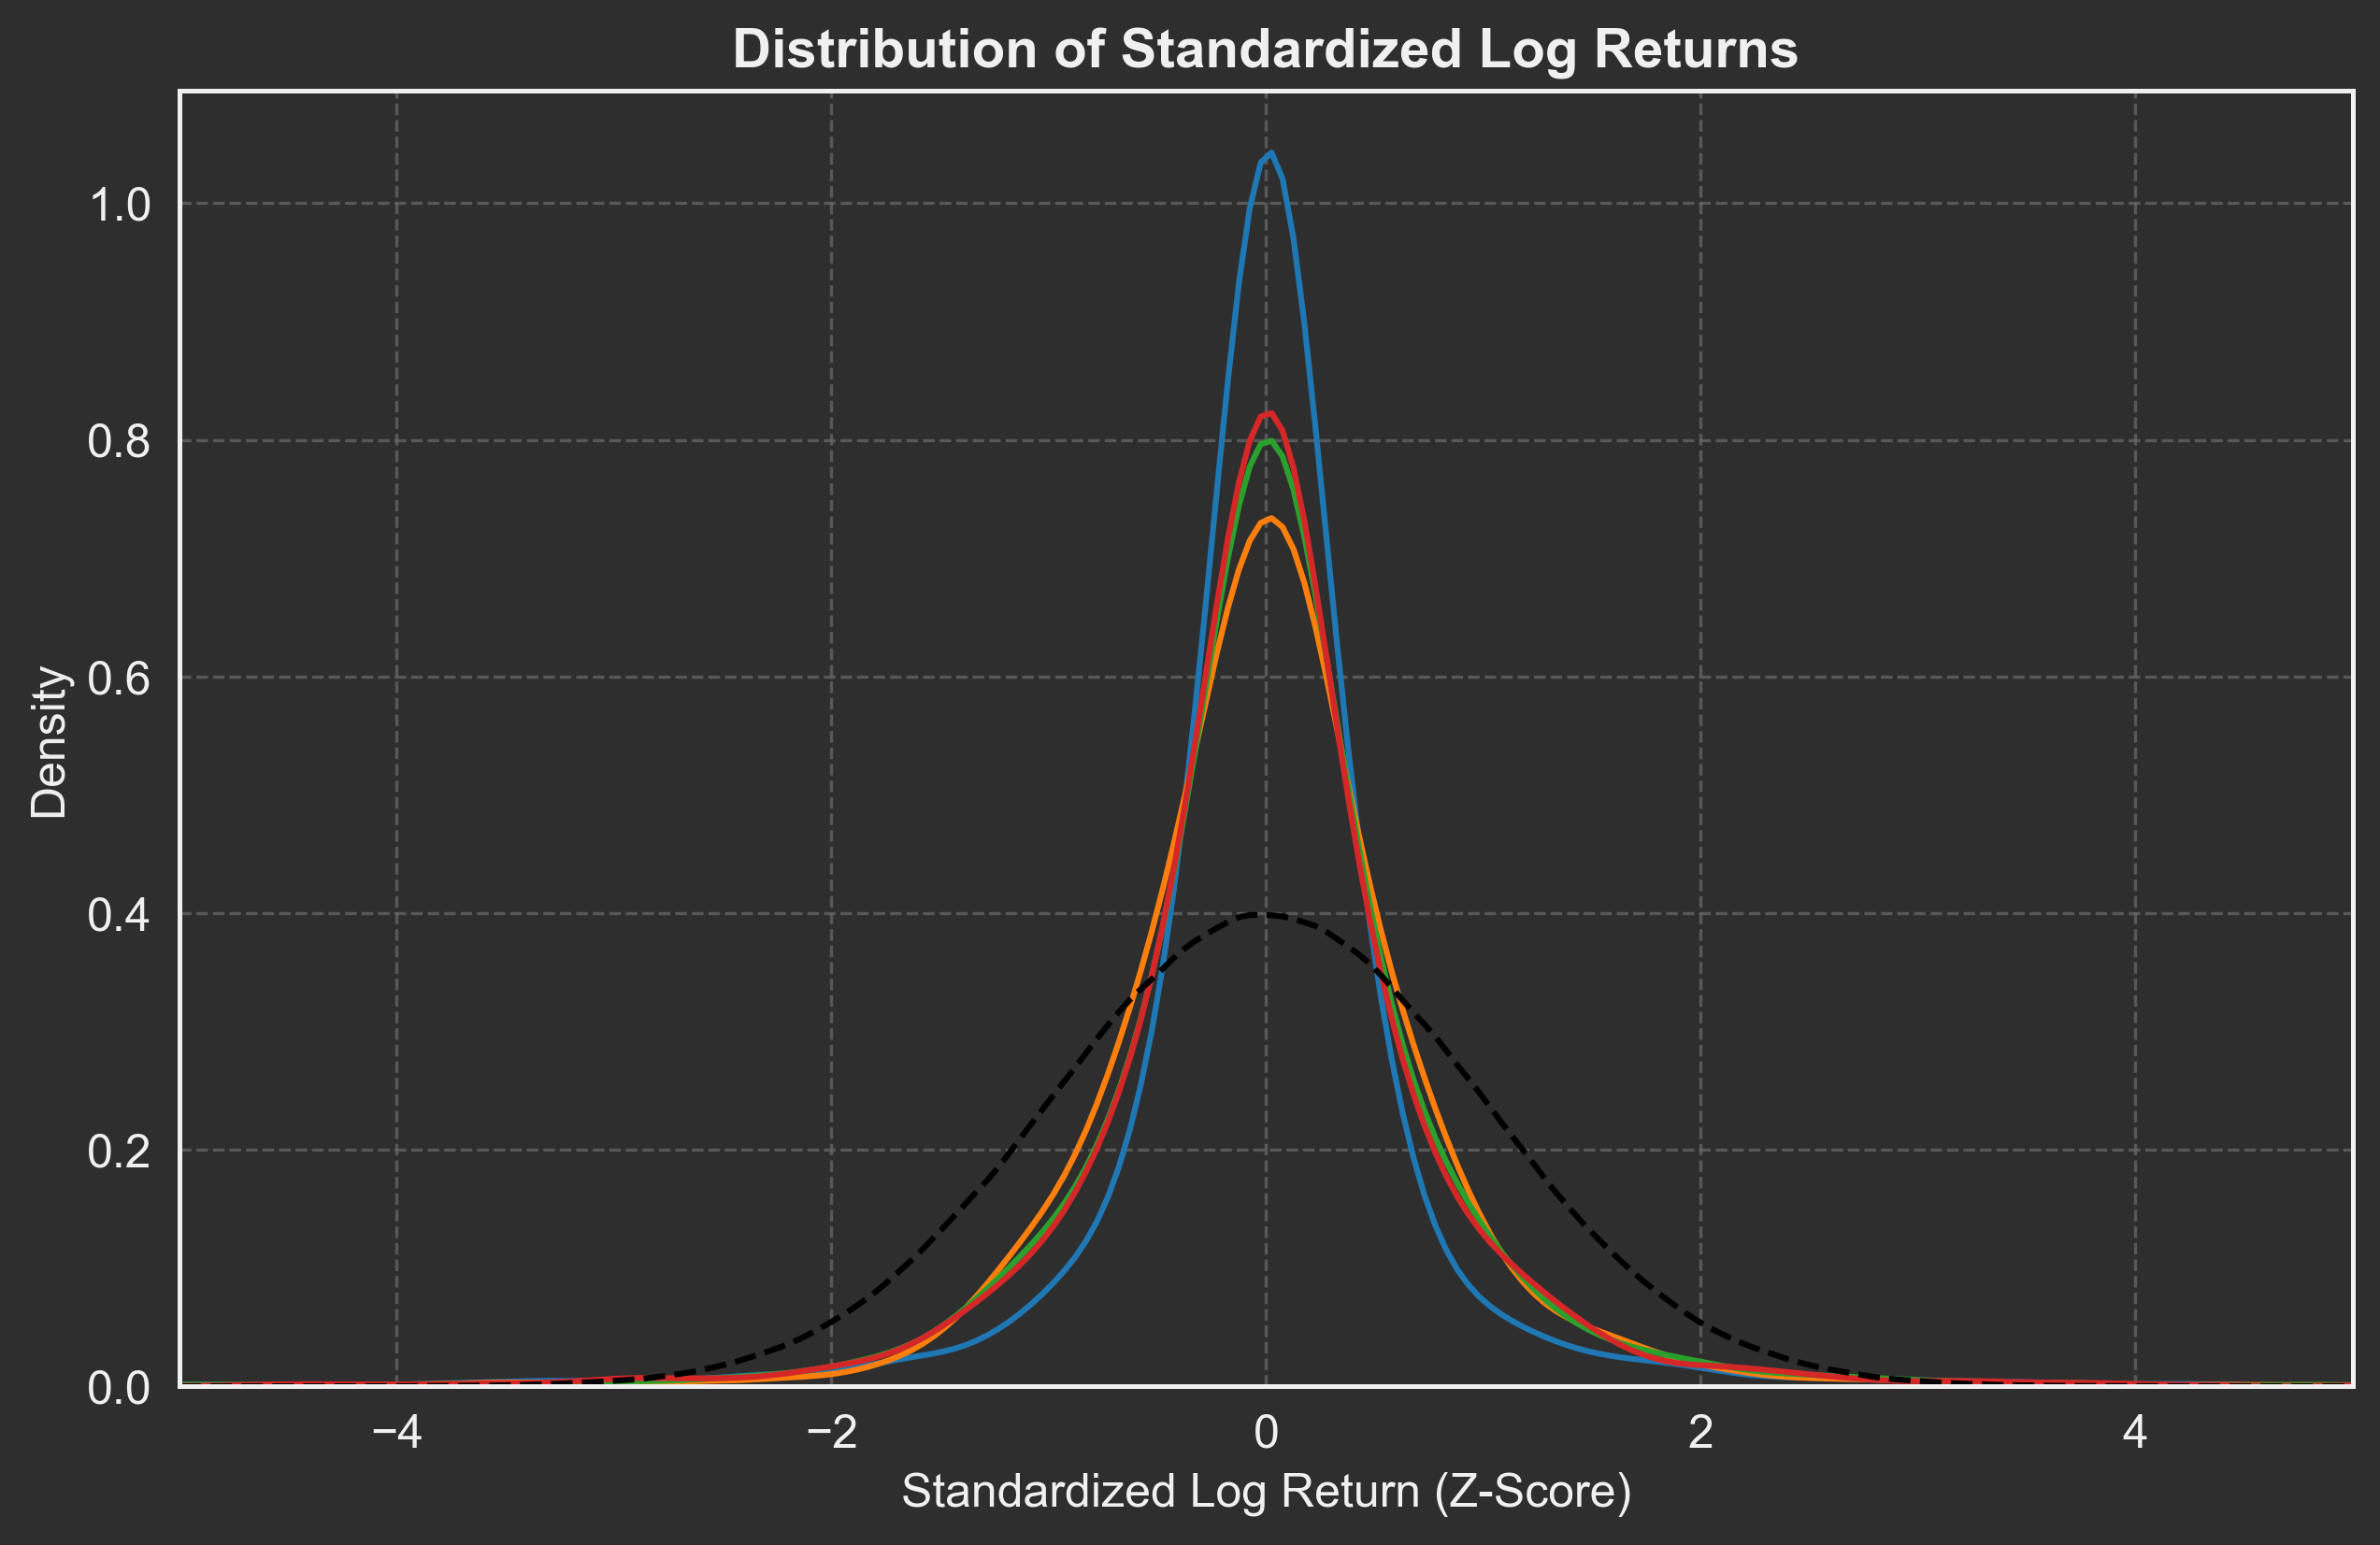

--- Jarque-Bera Test for Normality ---
(Lower is better)
Time Bars:   	5051265.86 (p=0)
Tick Bars:   	3739265.91 (p=0)
Volume Bars: 	 906508.16 (p=0)
Dollar Bars: 	 914396.89 (p=0)


In [ ]:
# --- 1. Calculate Log Returns ---
# We store the returns in a dictionary, NOT a DataFrame.
# This is because each Series has a different length, which is expected.
# We remove the .values to keep them as named pandas Series.
returns_dict = {
    'Time': np.log(time_bars['Close']).diff().dropna(),
    'Tick': np.log(tick_bars['Close']).diff().dropna(),
    'Volume': np.log(volume_bars['Close']).diff().dropna(),
    'Dollar': np.log(dollar_bars['Close']).diff().dropna(),
}

# --- 2. Standardize (z-score) for a clean comparison ---
# This part of the code works perfectly with the new returns_dict
standardized_returns = {
    'Time': (returns_dict['Time'] - returns_dict['Time'].mean()) / returns_dict['Time'].std(),
    'Tick': (returns_dict['Tick'] - returns_dict['Tick'].mean()) / returns_dict['Tick'].std(),
    'Volume': (returns_dict['Volume'] - returns_dict['Volume'].mean()) / returns_dict['Volume'].std(),
    'Dollar': (returns_dict['Dollar'] - returns_dict['Dollar'].mean()) / returns_dict['Dollar'].std(),
}

# --- 3. Plot the distributions ---
# This plotting code will work as-is.
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(standardized_returns['Time'], label='Time Bars', ax=ax, clip=(-5, 5))
sns.kdeplot(standardized_returns['Tick'], label='Tick Bars', ax=ax, clip=(-5, 5))
sns.kdeplot(standardized_returns['Volume'], label='Volume Bars', ax=ax, clip=(-5, 5))
sns.kdeplot(standardized_returns['Dollar'], label='Dollar Bars', ax=ax, clip=(-5, 5))
sns.kdeplot(np.random.normal(size=1000000), label='Normal (Ref.)', linestyle='--', color='black', ax=ax, clip=(-5, 5))

ax.set_xlim(-5, 5)
pub_plots.apply_plot_style(
    ax,
    title='Distribution of Standardized Log Returns',
    xlabel='Standardized Log Return (Z-Score)',
    ylabel='Density',
    legend_title='Bar Type'
)

pub_plots.finalize_plot(fig, "return_distributions.png")

# --- 4. Run the Jarque-Bera Test ---
# We update this part to use our 'returns_dict' instead of the non-existent 'returns_df'
print("--- Jarque-Bera Test for Normality ---")
print(f"(Lower is better)")

# Use the Series from returns_dict (they are already .dropna())
jb_time = stats.jarque_bera(returns_dict['Time'])
jb_tick = stats.jarque_bera(returns_dict['Tick'])
jb_volume = stats.jarque_bera(returns_dict['Volume'])
jb_dollar = stats.jarque_bera(returns_dict['Dollar'])

print(f"Time Bars:   \t{jb_time[0]:>10.2f} (p={jb_time[1]:.0f})")
print(f"Tick Bars:   \t{jb_tick[0]:>10.2f} (p={jb_tick[1]:.0f})")
print(f"Volume Bars: \t{jb_volume[0]:>10.2f} (p={jb_volume[1]:.0f})")
print(f"Dollar Bars: \t{jb_dollar[0]:>10.2f} (p={jb_dollar[1]:.0f})")

In [ ]:
# --- Run the Jarque-Bera Test ---
# We update this part to use our 'returns_dict' instead of the non-existent 'returns_df'
print("--- Jarque-Bera Test for Normality ---")
print(f"(Lower is better)")

# Use the Series from returns_dict (they are already .dropna())
jb_time = stats.jarque_bera(returns_dict['Time'])
jb_tick = stats.jarque_bera(returns_dict['Tick'])
jb_volume = stats.jarque_bera(returns_dict['Volume'])
jb_dollar = stats.jarque_bera(returns_dict['Dollar'])

print(f"Time Bars:   \t{jb_time[0]:>10.2f} (p={jb_time[1]:.0f})")
print(f"Tick Bars:   \t{jb_tick[0]:>10.2f} (p={jb_tick[1]:.0f})")
print(f"Volume Bars: \t{jb_volume[0]:>10.2f} (p={jb_volume[1]:.0f})")
print(f"Dollar Bars: \t{jb_dollar[0]:>10.2f} (p={jb_dollar[1]:.0f})")

--- Jarque-Bera Test for Normality ---
(Lower is better)
Time Bars:   	5051265.86 (p=0)
Tick Bars:   	3739265.91 (p=0)
Volume Bars: 	 906508.16 (p=0)
Dollar Bars: 	 914396.89 (p=0)


**Observation:** The results are clear. The Time bars have a very high Jarque-Bera statistic, showing they are extremely non-normal (high kurtosis, or 'fat tails'). The **Dollar Bars** have the lowest statistic, and their distribution plot is visibly the closest to the normal reference. This confirms they are the most statistically 'well-behaved' data structure.

## 4. Information-Driven Bars

Information-Driven Bars are more advanced. They sample not when a *threshold* is met, but when a *disequilibrium* in trade flow is detected.

### 4.1. Imbalance Bars

In [ ]:
# 1. Instantiate the ExpectedImbalanceBars class
e_imb_bar_generator = ExpectedImbalanceBars(
    bar_type="dollar_imbalance",
    window_size_for_expected_n_ticks_estimation=500, # EWMA window for E[T]
    initial_estimate_of_expected_n_ticks_in_bar=2000,
    window_size_for_expected_imbalance_estimation=10000 # EWMA window for E[b]
)

# 2. Construct the bars
e_imb_bars_list = e_imb_bar_generator.construct_bars_from_data(tick_data_iterable)

# 3. Convert to a DataFrame
e_imb_bars = bars_to_dataframe(e_imb_bars_list)

print(f"Generated {len(e_imb_bars)} Expected Dollar Imbalance Bars.")
e_imb_bars.head()

Generated 4 Expected Dollar Imbalance Bars.


,Tick Index,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar,Threshold
Date Time,,,,,,,,,,,
2020-01-09 12:57:11,5385,130.6800,130.78,128.93,130.120,3710990,1688064,2022926,5385,4.819817e+08,4.034164e+07
2020-02-20 10:11:45,26217,130.1300,132.10,126.21,131.400,8810799,4159990,4650809,20832,1.145235e+09,6.038765e+07
2020-02-27 10:02:22,35483,131.4311,131.55,118.63,119.252,4771531,3300187,1471344,9266,5.872199e+08,6.448313e+07
2020-06-03 12:33:38,179802,118.7800,121.60,81.70,113.479,58958136,25750159,33207977,144319,5.970515e+09,5.894138e+08


### 4.2. Run Bars

In [ ]:
# 1. Instantiate the ExpectedRunBars class
e_run_bar_generator = ExpectedRunBars(
    bar_type="dollar_run",
    window_size_for_expected_n_ticks_estimation=500,
    initial_estimate_of_expected_n_ticks_in_bar=2000,
    window_size_for_expected_imbalance_estimation=10000
)

# 2. Construct the bars
e_run_bars_list = e_run_bar_generator.construct_bars_from_data(tick_data_iterable)

# 3. Convert to a DataFrame
e_run_bars = bars_to_dataframe(e_run_bars_list)

print(f"Generated {len(e_run_bars)} Expected Dollar Run Bars.")
e_run_bars.head()

Generated 37 Expected Dollar Run Bars.


,Tick Index,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar,Threshold
Date Time,,,,,,,,,,,
2020-01-08 09:30:53,4054,130.6800,130.7800,128.93,129.31,3042784,1388680,1654104,4054,3.951182e+08,9.981239e+07
2020-01-21 10:54:54,10723,129.3300,131.8646,129.33,131.25,2844299,1292927,1551372,6669,3.713370e+08,2.023197e+08
2020-01-31 11:13:21,17626,131.2600,131.7400,127.15,127.15,2722781,1317088,1405693,6903,3.529372e+08,1.814722e+08
2020-02-11 10:20:02,23248,127.1600,131.5043,126.21,131.47,2514714,1203938,1310776,5622,3.242637e+08,1.690541e+08
2020-02-24 14:39:48,28922,131.4753,132.1000,126.29,127.16,2455729,1178260,1277469,5674,3.202470e+08,1.665920e+08


## 5. Alternative Method: Using the Controller

While manual instantiation is good for understanding, the `RiskLabAI` library provides a `Controller` class that simplifies this process, especially for processing large files in batches.

In [ ]:
# 1. Prepare the data for the controller
# The controller expects a DataFrame with columns [datetime, price, volume]
controller_data_df = raw_df[['dates', 'price', 'size']].copy()

# 2. Instantiate the controller
controller = Controller()

# 3. Define the bar type and arguments
method_name = 'dollar_standard_bars'
method_arguments = {
    'threshold': dollar_threshold
}

# 4. Handle the command
# This single command processes the data (in batches) and returns a DataFrame
controller_bars_df = controller.handle_input_command(
    method_name=method_name,
    method_arguments=method_arguments,
    input_data=controller_data_df
)

print(f"\nGenerated {len(controller_bars_df)} Dollar Bars using the Controller.")
controller_bars_df.head()

Processing data in batches...
Done. Constructed 4162 bars.

Generated 4162 Dollar Bars using the Controller.


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2020-01-02 09:30:04,4,130.68,130.68,130.500,130.55,21025,200,20825,4,2.747483e+06,2.737634e+06
1,2020-01-02 09:33:00,74,130.53,130.78,130.520,130.59,21349,9495,11854,70,2.788581e+06,2.737634e+06
2,2020-01-02 09:33:22,90,130.59,130.62,130.590,130.61,54400,6400,48000,16,7.105119e+06,2.737634e+06
3,2020-01-02 09:43:40,175,130.63,130.67,130.450,130.54,21013,9054,11959,85,2.743340e+06,2.737634e+06
4,2020-01-02 09:44:31,188,130.54,130.55,130.525,130.54,24319,21407,2912,13,3.174578e+06,2.737634e+06
